## LSTM for Time Series Prediction in PyTorch

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.6.18</div>
<div style="text-align: right"> Last update: 2023.6.18</div>

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [3]:
df = pd.read_csv('data/air-passengers.csv')

In [4]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
timeseries = df[['Passengers']].values.astype('float32')

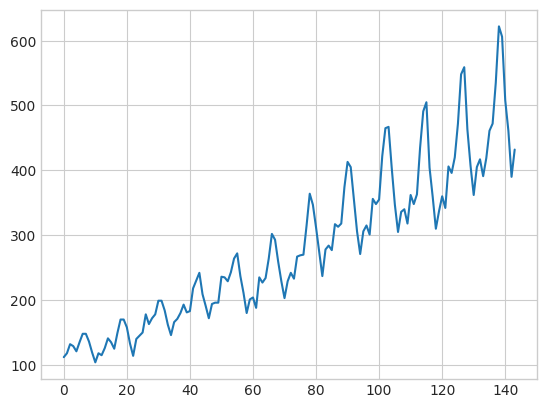

In [6]:
plt.plot(timeseries)
plt.show()

In [7]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [8]:
train.shape

(96, 1)

In [9]:
train[:5]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.]], dtype=float32)

In [10]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i: i+lookback]
        target = dataset[i+1: i+lookback+1]
        X.append(feature)
        y.append(target)
        
    return torch.tensor(X), torch.tensor(y)

- 위 함수는 시계열을 (window sample, time steps, features) 모양으로 변환하도록 설계됨

lookback = 1로 설정하고 데이터를 만들어보자.

In [11]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


이제 모델을 만들어본다.

In [12]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = 1, 
            hidden_size=50, 
            num_layers = 1, batch_first = True
            )
        self.linear = nn.Linear(50, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x) # 출력이 튜플임, 첫번째는 각 입력에 따른 히든 스테이트의 출력, 두번째는 셀메모리
        x = self.linear(x)
        return x

만약 LSTM의 마지막 출력만 가져오고 싶으면 다음과 같이 입력한다.

```python
x, _ = self.lstm(x)
# extract only the last time step
x = x[:, -1, :]
x = self.linear(x)
```

회귀 문제이므로 MSE, ADAM 적용   
그리고 데이터는 tensordataset과 조합한다.

In [13]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                         shuffle = True,
                         batch_size = 8
                         )

In [14]:
model

AirModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [15]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % \
        (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.9390, test RMSE 422.3704
Epoch 100: train RMSE 189.9402, test RMSE 384.7190
Epoch 200: train RMSE 159.1108, test RMSE 351.6774
Epoch 300: train RMSE 131.8505, test RMSE 321.2031
Epoch 400: train RMSE 108.7706, test RMSE 293.3924
Epoch 500: train RMSE 90.4325, test RMSE 268.2522
Epoch 600: train RMSE 74.1854, test RMSE 244.3526
Epoch 700: train RMSE 60.4769, test RMSE 221.7094
Epoch 800: train RMSE 49.8667, test RMSE 201.1015
Epoch 900: train RMSE 41.6994, test RMSE 182.4333
Epoch 1000: train RMSE 35.6367, test RMSE 166.0338
Epoch 1100: train RMSE 31.4559, test RMSE 151.9175
Epoch 1200: train RMSE 28.5711, test RMSE 140.0307
Epoch 1300: train RMSE 28.5124, test RMSE 129.9005
Epoch 1400: train RMSE 25.9310, test RMSE 122.5155
Epoch 1500: train RMSE 24.8158, test RMSE 116.4515
Epoch 1600: train RMSE 24.9200, test RMSE 112.6926
Epoch 1700: train RMSE 23.9316, test RMSE 107.8276
Epoch 1800: train RMSE 24.4883, test RMSE 104.0051
Epoch 1900: train RMSE 23.8778, test R

결과를 차트로 그려본다.

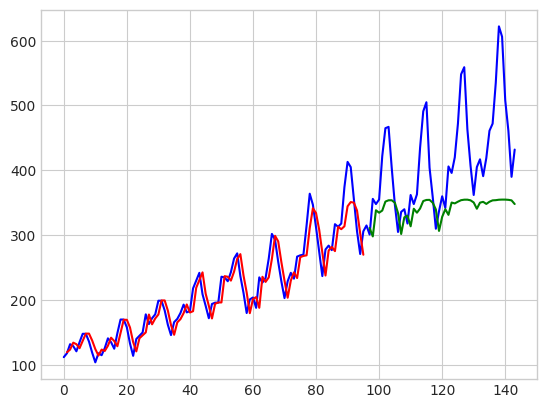

In [16]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :] # 모델의 마지막 출력만 추출함
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
    
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

아래는 lookback을 4로 설정한 전체 코드이다.

Epoch 0: train RMSE 225.5168, test RMSE 424.7209
Epoch 100: train RMSE 172.8234, test RMSE 369.3551
Epoch 200: train RMSE 134.0331, test RMSE 326.4688
Epoch 300: train RMSE 103.8797, test RMSE 289.4143
Epoch 400: train RMSE 79.6921, test RMSE 255.3530
Epoch 500: train RMSE 61.6877, test RMSE 224.5503
Epoch 600: train RMSE 48.5556, test RMSE 197.9746
Epoch 700: train RMSE 39.6147, test RMSE 174.6288
Epoch 800: train RMSE 33.2292, test RMSE 154.4541
Epoch 900: train RMSE 29.1300, test RMSE 137.4959
Epoch 1000: train RMSE 26.1942, test RMSE 123.5703
Epoch 1100: train RMSE 24.1850, test RMSE 111.5334
Epoch 1200: train RMSE 22.8769, test RMSE 102.6251
Epoch 1300: train RMSE 22.2371, test RMSE 96.3231
Epoch 1400: train RMSE 21.8701, test RMSE 90.1065
Epoch 1500: train RMSE 21.2854, test RMSE 85.7239
Epoch 1600: train RMSE 20.4131, test RMSE 83.3547
Epoch 1700: train RMSE 20.3003, test RMSE 80.5352
Epoch 1800: train RMSE 19.9355, test RMSE 78.4043
Epoch 1900: train RMSE 19.6220, test RMSE 76.

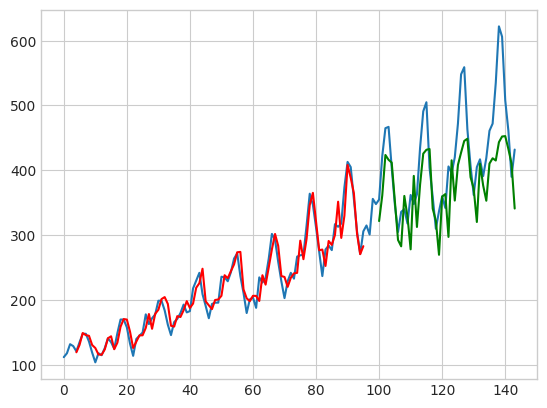

In [17]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

- lookback을 늘리니까 성능이 개선되었다.

정리하면 예를 들어 lookback이 4 이면,   
입력을 t ~ t+3까지 받아서, t1 ~ t+4를 예측하는 모델이다.   
그러나 t+1 ~ t+3은 알고 있는 값이다.